# Notebook to analyze an MCMC chain

In [80]:
import matplotlib.pyplot as plt
import pylab
import numpy as np
import healpy as hp
import emcee
from scipy import stats
import corner
import sys
import ModelDefinitions as MD
import LogProb as LP
from const import *
from IPython.display import display, Math
%matplotlib inline

Read in the chain, and set up some parameters for everything below. 
To change:
* the filename (fname)
* the burn-in end sample (bnin)
* the model number (model_num 0=disk+bkg, 1=disk+halo, 2=disk+bkg+halo)

In [116]:
fname = 'results/output_dh_2.npz' # filename
chains = (np.load(fname))['samples']
bnin = 600 # burn-in end sample
model_num = 2

# get chain parameters and trim
ndim = chains.shape[2]
nsamps = chains.shape[1]
nchains = chains.shape[0]
chains = chains[:,bnin:,:]

# model cases
if model_num==0:
    labls=['T_b','R_d','h_d','j_d']
    ndim=4
    chains[:,:,3] = np.log10(chains[:,:,3])
if model_num==1:
    labls=['R_d','h_d','j_d','R_h','j_h']
    ndim=5
    chains[:,:,2] = np.log10(chains[:,:,2])
    chains[:,:,4] = np.log10(chains[:,:,4])
if model_num==2:
    labls=['T_b','R_d','h_d','j_d','R_h','j_h']
    ndim=6
    chains[:,:,3] = np.log10(chains[:,:,3])
    chains[:,:,5] = np.log10(chains[:,:,5])



## 1. Plot the samplers

Plot each chain for each parameter. Only plot samples after bnin. 

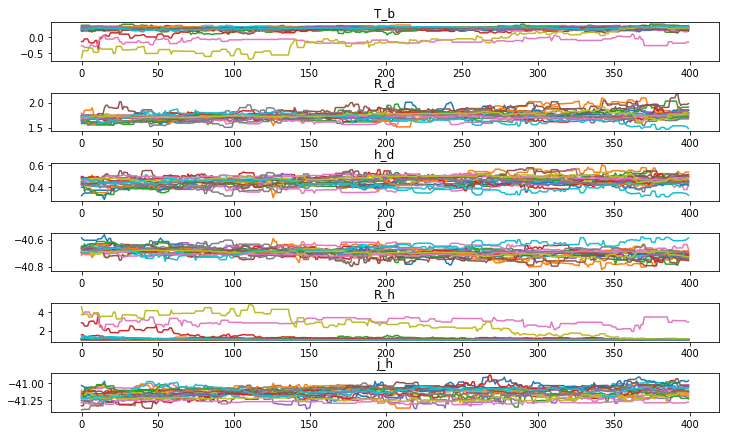

In [117]:
fig,axes = plt.subplots(nrows=ndim,ncols=1,figsize=(10.,6.))
fig.tight_layout()
for param in range(ndim):
    pylab.subplot(ndim,1,param+1)
    for ch in range(nchains):
        plt.plot(chains[ch,:,param],'-')
        plt.title(labls[param])

plt.show()

## 2. Make the corner plot

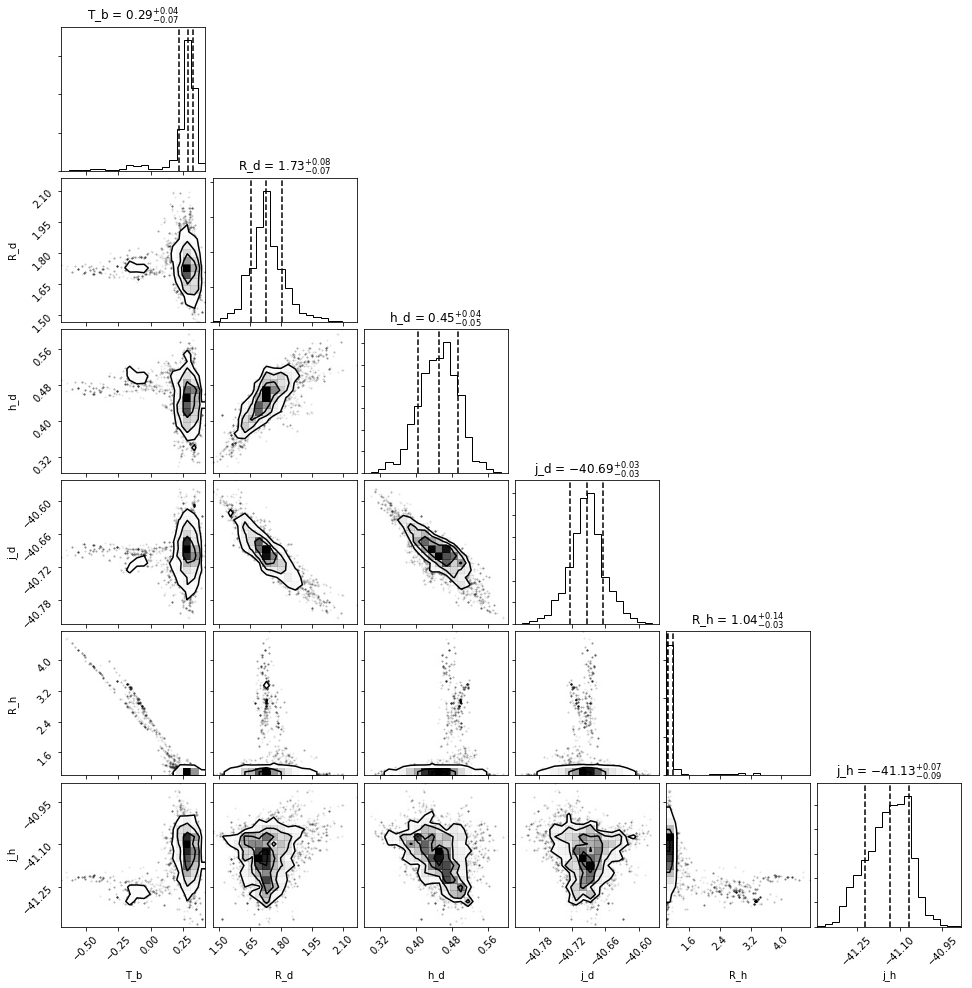

In [118]:
samples = chains.reshape((-1,ndim))
fig=corner.corner(samples,labels=labls,quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12})

## 3. Measure the values of the parameters

The 16th, 50th and 84th percentiles are shown. Also prints the BIC, using the number of spherical harmonics as the number of data points.

In [121]:
# measure parameters
params = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    params[i] = np.percentile(samples[:, i], 50)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labls[i])
    display(Math(txt))

# measure BIC
map_1420 = (hp.read_map('../STOCKERT+VILLA-ELISA_1420MHz_1_256.fits'))/1000 - T_CMB - T_eg
data = MD.prep_data(map_1420)
if model_num==0:
    params[1] *= d
    params[2] *= d
    params[3] = 10.**(params[3])
    lnlik = LP.lik_disk(params,data)
if model_num==1:
    params[0] *= d
    params[1] *= d
    params[2] = 10.**(params[2])
    params[3] *= d
    params[4] = 10.**(params[4])
    lnlik = LP.lik_disk_halo_nobkg(params,data)
if model_num==2:
    params[1] *= d
    params[2] *= d
    params[3] = 10.**(params[3])
    params[4] *= d
    params[5] = 10.**(params[5])
    lnlik = LP.lik_disk_halo(params,data)

BIC = np.log(len(lm_idx))*ndim-2.*lnlik
txt = "\mathrm{{{1}}} = {0:.3f}"
txt = txt.format(BIC, 'BIC')
display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


<IPython.core.display.Math object>

## 4. Make maps of data, model, and residuals

Use the degraded resolution for the maps for speed.

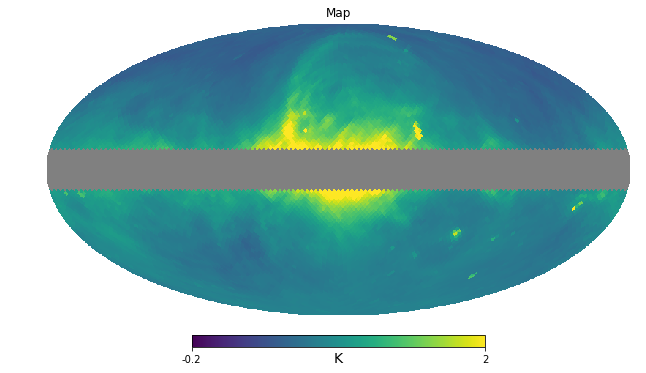

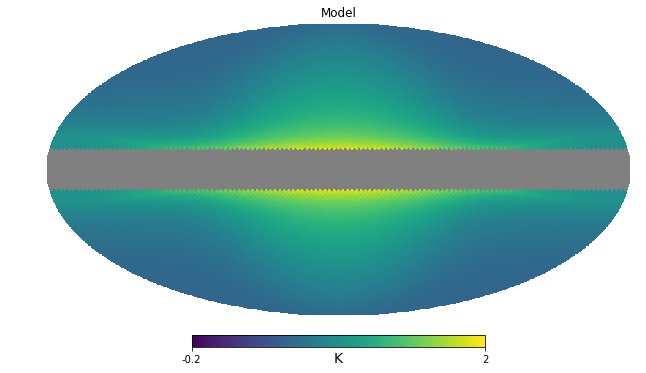

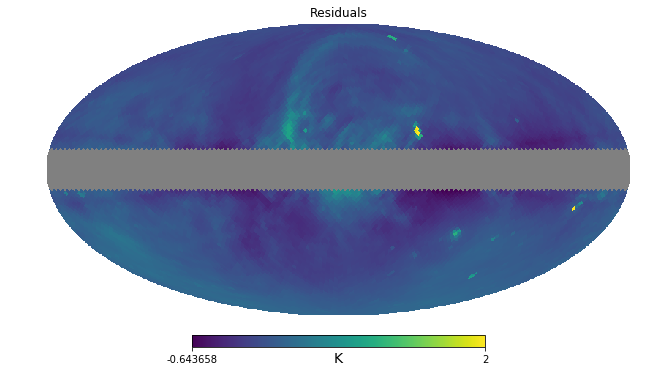

In [122]:
# read map, lower res and mask
map_1420_dg = hp.pixelfunc.ud_grade(map_1420, NSIDE_dg)
idx_exb = hp.query_strip(NSIDE_dg, np.deg2rad(90-b_mask*2), np.deg2rad(90+b_mask*2))
map_1420_dg[idx_exb] = None
hp.mollview(map_1420_dg,title='Map',unit='K',min=-0.2,max=2.0)

# make model
if model_num==0:
    T_bkg = params[0]
    R_disk = params[1]
    h_disk = params[2]
    j_disk = params[3]
    model = MD.LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk*(c**2)/(2*k*(nu**2)) + T_bkg
if model_num==1:
    R_disk = params[0]
    h_disk = params[1]
    j_disk = params[2]
    R_halo = params[3]
    j_halo = params[4]
    model = MD.LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk*(c**2)/(2*k*(nu**2)) + MD.LineOfSightHalo(l, b, d, R_halo)*j_halo*(c**2)/(2*k*(nu**2))
if model_num==2:
    T_bkg = params[0]
    R_disk = params[1]
    h_disk = params[2]
    j_disk = params[3]
    R_halo = params[4]
    j_halo = params[5]
    model = MD.LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk*(c**2)/(2*k*(nu**2)) + T_bkg + MD.LineOfSightHalo(l, b, d, R_halo)*j_halo*(c**2)/(2*k*(nu**2))
model[idx_exb] = None
hp.mollview(model,title='Model',unit='K',min=-0.2,max=2.0)   

# make residuals
hp.mollview(map_1420_dg-model,title='Residuals',unit='K',max=2.)   


## 5. Make csc b plots

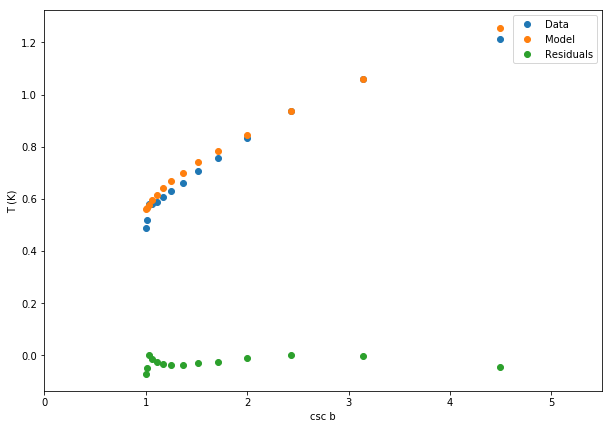

In [123]:
cscb1,dat = MD.cscbplot(map_1420_dg,NSIDE_dg)
cscb2,mod = MD.cscbplot(model,NSIDE_dg)
cscb3,res = MD.cscbplot(map_1420_dg-model,NSIDE_dg)

plt.figure(figsize=(10.,7.))
plt.xlim(0.,5.5)
plt.plot(cscb1,dat,'o',label='Data')
plt.plot(cscb2,mod,'o',label='Model')
plt.plot(cscb3,res,'o',label='Residuals')
plt.legend()
plt.xlabel('csc b')
plt.ylabel('T (K)')



